In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('../단국대(사용중)')
feature_dir = Path('../단국대(사용중)')
sub_dir = Path('../단국대(사용중)')
val_dir = Path('../단국대(사용중)')
tst_dir = Path('../단국대(사용중)')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 142)


,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,u_r,u_g,g_r,g_z,g_i,d_dered_u,d_dered_g,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,dered_u_min,dered_u_diff,dered_u_sum,dered_g_max,dered_g_min,dered_g_diff,dered_g_std,dered_g_sum,dered_r_max,dered_r_min,dered_r_diff,dered_r_std,dered_r_sum,dered_i_max,dered_i_min,dered_i_diff,dered_i_std,dered_z_max,dered_z_diff,dered_z_std,dered_z_sum,d_dered_u_d_dered_g_diff,d_dered_u_dered_r_diff,d_dered_u_d_dered_iz_diff,d_dered_u_d_dered_ig_diff,d_dered_u_d_dered_i_diff,d_dered_u_dered_i_diff,...,d_dered_r_dered_i_diff,d_dered_r_d_dered_zg_diff,dered_r_d_dered_iz_diff,dered_r_d_dered_i_diff,dered_r_dered_i_diff,dered_r_d_dered_zg_diff,dered_r_d_dered_z_diff,dered_r_dered_z_diff,d_dered_iz_d_dered_ig_diff,d_dered_iz_d_dered_i_diff,d_dered_iz_d_dered_zg_diff,d_dered_iz_d_dered_z_diff,d_dered_iz_dered_z_diff,d_dered_ig_d_dered_i_diff,d_dered_ig_dered_i_diff,d_dered_ig_d_dered_zg_diff,d_dered_ig_d_dered_z_diff,d_dered_ig_dered_z_diff,d_dered_i_d_dered_zg_diff,d_dered_i_d_dered_z_diff,d_dered_i_dered_z_diff,dered_i_d_dered_z_diff,dered_i_dered_z_diff,d_dered_zg_dered_z_diff,dered_u_dered_g_min_diff,dered_u_dered_g_sum_diff,dered_u_dered_r_max_diff,dered_u_dered_r_min_diff,dered_u_dered_r_sum_diff,dered_u_dered_i_sum_diff,dered_u_dered_z_max_diff,dered_u_dered_z_min_diff,dered_u_dered_z_sum_diff,dered_g_dered_r_max_diff,dered_g_dered_r_min_diff,dered_g_dered_r_sum_diff,dered_g_dered_i_max_diff,dered_g_dered_i_min_diff,dered_g_dered_i_sum_diff,dered_g_dered_z_max_diff,dered_g_dered_z_sum_diff,dered_r_dered_i_max_diff,dered_r_dered_i_min_diff,dered_r_dered_i_sum_diff,dered_r_dered_z_max_diff,dered_r_dered_z_min_diff,dered_r_dered_z_sum_diff,dered_i_dered_z_max_diff,dered_i_dered_z_min_diff,dered_i_dered_z_sum_diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,4.2545,2.9272,1.3273,3.3972,2.6643,0.9940,0.9961,0.9977,0.9982,0.8704,0.8347,1.1210,1.0428,1.0000,0.9940,22.1303,24.1183,20.2578,0.9961,19.2617,13.6201,21.2539,18.9551,0.9971,17.9580,10.3325,21.0733,17.6321,0.8704,16.7617,8.3312,16.9089,16.0743,9.2336,18.7418,-0.0021,-17.9611,-0.0488,0.1236,-0.0037,-16.6381,...,-16.6350,0.1625,17.9124,17.9574,1.3230,18.1204,17.9569,2.0462,0.1724,0.0451,0.2081,0.0446,-15.8662,-0.1273,-16.7617,0.0357,-0.1278,-16.0386,0.1630,-0.0005,-15.9112,16.6339,0.7232,-16.0743,-0.0021,2.8643,4.1691,-0.0031,3.0450,3.5753,6.2153,0.1593,5.3764,1.3027,-0.0010,0.1806,2.6257,0.1257,0.7109,3.3488,2.5121,1.3230,0.1268,0.5303,2.0462,0.1625,2.3315,0.7232,0.0357,1.8012
1,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,1.5997,0.9902,0.6096,0.8930,0.7935,0.9943,0.9959,0.9976,0.9974,0.9451,0.9379,1.0211,1.0077,1.0000,0.9943,13.9721,15.9607,14.0045,0.9959,13.0086,9.1985,15.0004,13.4114,0.9970,12.4144,7.1605,15.4294,13.2363,0.9451,12.2911,6.1264,13.1347,12.1968,7.0247,15.0700,-0.0016,-12.4171,-0.0134,0.0492,-0.0033,-12.2419,...,-12.2393,0.0591,12.4037,12.4138,0.1751,12.4735,12.4140,0.2767,0.0626,0.0102,0.0698,0.0103,-12.1269,-0.0524,-12.2911,0.0073,-0.0523,-12.1895,0.0597,0.0002,-12.1371,12.2389,0.1016,-12.1968,-0.0016,0.9603,1.5550,-0.0026,0.5313,-0.2260,1.8317,0.0564,0.8908,0.5931,-0.0010,-0.4290,0.7683,0.0508,-1.1863,0.8698,-0.0695,0.1751,0.0518,-0.7573,0.2767,0.0591,0.3594,0.1016,0.0073,1.1167
2,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,1.2501,0.9610,0.2891,0.4754,0.4319,0.9894,0.9912,0.9953,0.9965,0.9767,0.9751,1.0094,1.0017,1.0000,0.9894,15.6183,17.5970,15.6866,0.9912,14.6954,10.3912,16.6778,15.4400,0.9938,14.4462,8.3360,17.4433,15.3217,0.9767,14.3450,7.1652,15.2961,14.3210,8.2621,17.2677,-0.0019,-14.4507,-0.0123,0.0126,-0.0060,-14.3324,...,-14.3279,0.0187,14.4384,14.4447,0.1183,14.4649,14.4436,0.1440,0.0249,0.0063,0.0266,0.0052,-14.2944,-0.0186,-14.3450,0.0016,-0.0197,-14.3193,0.0202,-0.0011,-14.3007,

In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 141) (80000, 141)


In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [9]:
params = { 
    "objective": "multiclass",
    "n_estimators": 10000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])}

In [10]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=11, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|███████████████████████████████████████████████| 11/11 [18:09<00:00, 99.00s/trial, best loss: 0.15625250349582206]
{'objective': 'multiclass', 'n_estimators': 10000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.8, 'learning_rate': 0.011455815991792899, 'min_child_samples': 100, 'num_leaves': 127, 'subsample': 0.8}


# K-Fold

In [11]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

# Light GBM

In [12]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.969198
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.952101
[3]	valid_0's multi_logloss: 0.9369
[4]	valid_0's multi_logloss: 0.921634
[5]	valid_0's multi_logloss: 0.906027
[6]	valid_0's multi_logloss: 0.890846
[7]	valid_0's multi_logloss: 0.876886
[8]	valid_0's multi_logloss: 0.863304
[9]	valid_0's multi_logloss: 0.850078
[10]	valid_0's multi_logloss: 0.836494
[11]	valid_0's multi_logloss: 0.823276
[12]	valid_0's multi_logloss: 0.810835
[13]	valid_0's multi_logloss: 0.798519
[14]	valid_0's multi_logloss: 0.78626
[15]	valid_0's multi_logloss: 0.774323
[16]	valid_0's multi_logloss: 0.762937
[17]	valid_0's multi_logloss: 0.75159
[18]	valid_0's multi_logloss: 0.741112
[19]	valid_0's multi_logloss: 0.730273
[20]	valid_0's multi_logloss: 0.719725
[21]	valid_0's multi_logloss: 0.709421
[22]	valid_0's multi_logloss: 0.699888
[23]	valid_0's multi_logloss: 0.690049
[24]	valid_0's multi_logloss: 

[207]	valid_0's multi_logloss: 0.194726
[208]	valid_0's multi_logloss: 0.194284
[209]	valid_0's multi_logloss: 0.193801
[210]	valid_0's multi_logloss: 0.193318
[211]	valid_0's multi_logloss: 0.19284
[212]	valid_0's multi_logloss: 0.19239
[213]	valid_0's multi_logloss: 0.19198
[214]	valid_0's multi_logloss: 0.191613
[215]	valid_0's multi_logloss: 0.191202
[216]	valid_0's multi_logloss: 0.190745
[217]	valid_0's multi_logloss: 0.19031
[218]	valid_0's multi_logloss: 0.189871
[219]	valid_0's multi_logloss: 0.189434
[220]	valid_0's multi_logloss: 0.189056
[221]	valid_0's multi_logloss: 0.188638
[222]	valid_0's multi_logloss: 0.18827
[223]	valid_0's multi_logloss: 0.187905
[224]	valid_0's multi_logloss: 0.187511
[225]	valid_0's multi_logloss: 0.187111
[226]	valid_0's multi_logloss: 0.186716
[227]	valid_0's multi_logloss: 0.186325
[228]	valid_0's multi_logloss: 0.185932
[229]	valid_0's multi_logloss: 0.185579
[230]	valid_0's multi_logloss: 0.185206
[231]	valid_0's multi_logloss: 0.184847
[232]

[413]	valid_0's multi_logloss: 0.15908
[414]	valid_0's multi_logloss: 0.159031
[415]	valid_0's multi_logloss: 0.158989
[416]	valid_0's multi_logloss: 0.158951
[417]	valid_0's multi_logloss: 0.158913
[418]	valid_0's multi_logloss: 0.158867
[419]	valid_0's multi_logloss: 0.158818
[420]	valid_0's multi_logloss: 0.158765
[421]	valid_0's multi_logloss: 0.158727
[422]	valid_0's multi_logloss: 0.158682
[423]	valid_0's multi_logloss: 0.158639
[424]	valid_0's multi_logloss: 0.158592
[425]	valid_0's multi_logloss: 0.158548
[426]	valid_0's multi_logloss: 0.158507
[427]	valid_0's multi_logloss: 0.158473
[428]	valid_0's multi_logloss: 0.158433
[429]	valid_0's multi_logloss: 0.158397
[430]	valid_0's multi_logloss: 0.158362
[431]	valid_0's multi_logloss: 0.158323
[432]	valid_0's multi_logloss: 0.158281
[433]	valid_0's multi_logloss: 0.158254
[434]	valid_0's multi_logloss: 0.158215
[435]	valid_0's multi_logloss: 0.158169
[436]	valid_0's multi_logloss: 0.158124
[437]	valid_0's multi_logloss: 0.158084
[

[619]	valid_0's multi_logloss: 0.154697
[620]	valid_0's multi_logloss: 0.154693
[621]	valid_0's multi_logloss: 0.154684
[622]	valid_0's multi_logloss: 0.154673
[623]	valid_0's multi_logloss: 0.154668
[624]	valid_0's multi_logloss: 0.154665
[625]	valid_0's multi_logloss: 0.154654
[626]	valid_0's multi_logloss: 0.154633
[627]	valid_0's multi_logloss: 0.154624
[628]	valid_0's multi_logloss: 0.154614
[629]	valid_0's multi_logloss: 0.154603
[630]	valid_0's multi_logloss: 0.154599
[631]	valid_0's multi_logloss: 0.15459
[632]	valid_0's multi_logloss: 0.154584
[633]	valid_0's multi_logloss: 0.154574
[634]	valid_0's multi_logloss: 0.154574
[635]	valid_0's multi_logloss: 0.154566
[636]	valid_0's multi_logloss: 0.154559
[637]	valid_0's multi_logloss: 0.154555
[638]	valid_0's multi_logloss: 0.154545
[639]	valid_0's multi_logloss: 0.154534
[640]	valid_0's multi_logloss: 0.154524
[641]	valid_0's multi_logloss: 0.154514
[642]	valid_0's multi_logloss: 0.154507
[643]	valid_0's multi_logloss: 0.154503
[

[825]	valid_0's multi_logloss: 0.153843
[826]	valid_0's multi_logloss: 0.153846
[827]	valid_0's multi_logloss: 0.153843
[828]	valid_0's multi_logloss: 0.153839
[829]	valid_0's multi_logloss: 0.153839
[830]	valid_0's multi_logloss: 0.153839
[831]	valid_0's multi_logloss: 0.15384
[832]	valid_0's multi_logloss: 0.153836
[833]	valid_0's multi_logloss: 0.153837
[834]	valid_0's multi_logloss: 0.153832
[835]	valid_0's multi_logloss: 0.153832
[836]	valid_0's multi_logloss: 0.153829
[837]	valid_0's multi_logloss: 0.153823
[838]	valid_0's multi_logloss: 0.153822
[839]	valid_0's multi_logloss: 0.153827
[840]	valid_0's multi_logloss: 0.153826
[841]	valid_0's multi_logloss: 0.153831
[842]	valid_0's multi_logloss: 0.153827
[843]	valid_0's multi_logloss: 0.153826
[844]	valid_0's multi_logloss: 0.153828
[845]	valid_0's multi_logloss: 0.153828
[846]	valid_0's multi_logloss: 0.153828
[847]	valid_0's multi_logloss: 0.15383
[848]	valid_0's multi_logloss: 0.15383
Early stopping, best iteration is:
[838]	va

[182]	valid_0's multi_logloss: 0.210157
[183]	valid_0's multi_logloss: 0.20953
[184]	valid_0's multi_logloss: 0.208847
[185]	valid_0's multi_logloss: 0.208189
[186]	valid_0's multi_logloss: 0.207595
[187]	valid_0's multi_logloss: 0.206969
[188]	valid_0's multi_logloss: 0.20632
[189]	valid_0's multi_logloss: 0.205687
[190]	valid_0's multi_logloss: 0.205075
[191]	valid_0's multi_logloss: 0.204516
[192]	valid_0's multi_logloss: 0.203913
[193]	valid_0's multi_logloss: 0.203331
[194]	valid_0's multi_logloss: 0.202735
[195]	valid_0's multi_logloss: 0.20217
[196]	valid_0's multi_logloss: 0.201592
[197]	valid_0's multi_logloss: 0.201048
[198]	valid_0's multi_logloss: 0.20049
[199]	valid_0's multi_logloss: 0.199981
[200]	valid_0's multi_logloss: 0.199485
[201]	valid_0's multi_logloss: 0.198989
[202]	valid_0's multi_logloss: 0.198525
[203]	valid_0's multi_logloss: 0.19804
[204]	valid_0's multi_logloss: 0.19751
[205]	valid_0's multi_logloss: 0.197048
[206]	valid_0's multi_logloss: 0.196595
[207]	

[388]	valid_0's multi_logloss: 0.161539
[389]	valid_0's multi_logloss: 0.16149
[390]	valid_0's multi_logloss: 0.161436
[391]	valid_0's multi_logloss: 0.161374
[392]	valid_0's multi_logloss: 0.161324
[393]	valid_0's multi_logloss: 0.161271
[394]	valid_0's multi_logloss: 0.161216
[395]	valid_0's multi_logloss: 0.161158
[396]	valid_0's multi_logloss: 0.161102
[397]	valid_0's multi_logloss: 0.161038
[398]	valid_0's multi_logloss: 0.160981
[399]	valid_0's multi_logloss: 0.160925
[400]	valid_0's multi_logloss: 0.160864
[401]	valid_0's multi_logloss: 0.160817
[402]	valid_0's multi_logloss: 0.160762
[403]	valid_0's multi_logloss: 0.160715
[404]	valid_0's multi_logloss: 0.160669
[405]	valid_0's multi_logloss: 0.160617
[406]	valid_0's multi_logloss: 0.160565
[407]	valid_0's multi_logloss: 0.160512
[408]	valid_0's multi_logloss: 0.160463
[409]	valid_0's multi_logloss: 0.160422
[410]	valid_0's multi_logloss: 0.160378
[411]	valid_0's multi_logloss: 0.160326
[412]	valid_0's multi_logloss: 0.160277
[

[594]	valid_0's multi_logloss: 0.156013
[595]	valid_0's multi_logloss: 0.155999
[596]	valid_0's multi_logloss: 0.155991
[597]	valid_0's multi_logloss: 0.155986
[598]	valid_0's multi_logloss: 0.155974
[599]	valid_0's multi_logloss: 0.155965
[600]	valid_0's multi_logloss: 0.155962
[601]	valid_0's multi_logloss: 0.155946
[602]	valid_0's multi_logloss: 0.15593
[603]	valid_0's multi_logloss: 0.155923
[604]	valid_0's multi_logloss: 0.155916
[605]	valid_0's multi_logloss: 0.155906
[606]	valid_0's multi_logloss: 0.155896
[607]	valid_0's multi_logloss: 0.155883
[608]	valid_0's multi_logloss: 0.155867
[609]	valid_0's multi_logloss: 0.155861
[610]	valid_0's multi_logloss: 0.155852
[611]	valid_0's multi_logloss: 0.155845
[612]	valid_0's multi_logloss: 0.155832
[613]	valid_0's multi_logloss: 0.155819
[614]	valid_0's multi_logloss: 0.155806
[615]	valid_0's multi_logloss: 0.1558
[616]	valid_0's multi_logloss: 0.155788
[617]	valid_0's multi_logloss: 0.155776
[618]	valid_0's multi_logloss: 0.155763
[61

[800]	valid_0's multi_logloss: 0.154878
[801]	valid_0's multi_logloss: 0.154874
[802]	valid_0's multi_logloss: 0.154874
[803]	valid_0's multi_logloss: 0.154869
[804]	valid_0's multi_logloss: 0.154866
[805]	valid_0's multi_logloss: 0.15487
[806]	valid_0's multi_logloss: 0.154874
[807]	valid_0's multi_logloss: 0.154869
[808]	valid_0's multi_logloss: 0.154869
[809]	valid_0's multi_logloss: 0.15487
[810]	valid_0's multi_logloss: 0.154866
[811]	valid_0's multi_logloss: 0.154863
[812]	valid_0's multi_logloss: 0.154856
[813]	valid_0's multi_logloss: 0.154857
[814]	valid_0's multi_logloss: 0.154852
[815]	valid_0's multi_logloss: 0.15485
[816]	valid_0's multi_logloss: 0.15485
[817]	valid_0's multi_logloss: 0.154855
[818]	valid_0's multi_logloss: 0.154849
[819]	valid_0's multi_logloss: 0.154848
[820]	valid_0's multi_logloss: 0.154844
[821]	valid_0's multi_logloss: 0.154841
[822]	valid_0's multi_logloss: 0.154835
[823]	valid_0's multi_logloss: 0.154832
[824]	valid_0's multi_logloss: 0.154832
[825

[145]	valid_0's multi_logloss: 0.24206
[146]	valid_0's multi_logloss: 0.24096
[147]	valid_0's multi_logloss: 0.239822
[148]	valid_0's multi_logloss: 0.238865
[149]	valid_0's multi_logloss: 0.237754
[150]	valid_0's multi_logloss: 0.236663
[151]	valid_0's multi_logloss: 0.235585
[152]	valid_0's multi_logloss: 0.234518
[153]	valid_0's multi_logloss: 0.233485
[154]	valid_0's multi_logloss: 0.232464
[155]	valid_0's multi_logloss: 0.231458
[156]	valid_0's multi_logloss: 0.230505
[157]	valid_0's multi_logloss: 0.229523
[158]	valid_0's multi_logloss: 0.228638
[159]	valid_0's multi_logloss: 0.227674
[160]	valid_0's multi_logloss: 0.226745
[161]	valid_0's multi_logloss: 0.225877
[162]	valid_0's multi_logloss: 0.225027
[163]	valid_0's multi_logloss: 0.224126
[164]	valid_0's multi_logloss: 0.223242
[165]	valid_0's multi_logloss: 0.222484
[166]	valid_0's multi_logloss: 0.221653
[167]	valid_0's multi_logloss: 0.220803
[168]	valid_0's multi_logloss: 0.22006
[169]	valid_0's multi_logloss: 0.21935
[170

[351]	valid_0's multi_logloss: 0.164598
[352]	valid_0's multi_logloss: 0.164512
[353]	valid_0's multi_logloss: 0.164417
[354]	valid_0's multi_logloss: 0.164327
[355]	valid_0's multi_logloss: 0.164243
[356]	valid_0's multi_logloss: 0.164157
[357]	valid_0's multi_logloss: 0.164064
[358]	valid_0's multi_logloss: 0.163975
[359]	valid_0's multi_logloss: 0.163889
[360]	valid_0's multi_logloss: 0.163808
[361]	valid_0's multi_logloss: 0.163731
[362]	valid_0's multi_logloss: 0.163653
[363]	valid_0's multi_logloss: 0.163581
[364]	valid_0's multi_logloss: 0.163505
[365]	valid_0's multi_logloss: 0.163426
[366]	valid_0's multi_logloss: 0.163357
[367]	valid_0's multi_logloss: 0.163277
[368]	valid_0's multi_logloss: 0.163203
[369]	valid_0's multi_logloss: 0.163141
[370]	valid_0's multi_logloss: 0.163071
[371]	valid_0's multi_logloss: 0.163006
[372]	valid_0's multi_logloss: 0.162936
[373]	valid_0's multi_logloss: 0.162874
[374]	valid_0's multi_logloss: 0.162805
[375]	valid_0's multi_logloss: 0.162737


[557]	valid_0's multi_logloss: 0.157045
[558]	valid_0's multi_logloss: 0.15703
[559]	valid_0's multi_logloss: 0.157015
[560]	valid_0's multi_logloss: 0.157002
[561]	valid_0's multi_logloss: 0.156986
[562]	valid_0's multi_logloss: 0.156974
[563]	valid_0's multi_logloss: 0.156968
[564]	valid_0's multi_logloss: 0.156948
[565]	valid_0's multi_logloss: 0.156936
[566]	valid_0's multi_logloss: 0.156923
[567]	valid_0's multi_logloss: 0.156918
[568]	valid_0's multi_logloss: 0.156905
[569]	valid_0's multi_logloss: 0.156887
[570]	valid_0's multi_logloss: 0.156877
[571]	valid_0's multi_logloss: 0.156866
[572]	valid_0's multi_logloss: 0.156858
[573]	valid_0's multi_logloss: 0.156852
[574]	valid_0's multi_logloss: 0.156844
[575]	valid_0's multi_logloss: 0.156832
[576]	valid_0's multi_logloss: 0.156817
[577]	valid_0's multi_logloss: 0.156808
[578]	valid_0's multi_logloss: 0.156793
[579]	valid_0's multi_logloss: 0.156781
[580]	valid_0's multi_logloss: 0.156772
[581]	valid_0's multi_logloss: 0.156764
[

[14]	valid_0's multi_logloss: 0.786679
[15]	valid_0's multi_logloss: 0.774778
[16]	valid_0's multi_logloss: 0.763424
[17]	valid_0's multi_logloss: 0.752114
[18]	valid_0's multi_logloss: 0.741659
[19]	valid_0's multi_logloss: 0.730871
[20]	valid_0's multi_logloss: 0.720337
[21]	valid_0's multi_logloss: 0.710065
[22]	valid_0's multi_logloss: 0.700562
[23]	valid_0's multi_logloss: 0.690761
[24]	valid_0's multi_logloss: 0.681171
[25]	valid_0's multi_logloss: 0.672477
[26]	valid_0's multi_logloss: 0.663311
[27]	valid_0's multi_logloss: 0.65433
[28]	valid_0's multi_logloss: 0.645561
[29]	valid_0's multi_logloss: 0.636982
[30]	valid_0's multi_logloss: 0.629047
[31]	valid_0's multi_logloss: 0.62083
[32]	valid_0's multi_logloss: 0.612938
[33]	valid_0's multi_logloss: 0.605061
[34]	valid_0's multi_logloss: 0.597354
[35]	valid_0's multi_logloss: 0.589806
[36]	valid_0's multi_logloss: 0.582689
[37]	valid_0's multi_logloss: 0.575462
[38]	valid_0's multi_logloss: 0.568383
[39]	valid_0's multi_loglos

[222]	valid_0's multi_logloss: 0.189488
[223]	valid_0's multi_logloss: 0.189113
[224]	valid_0's multi_logloss: 0.188709
[225]	valid_0's multi_logloss: 0.188316
[226]	valid_0's multi_logloss: 0.187924
[227]	valid_0's multi_logloss: 0.187541
[228]	valid_0's multi_logloss: 0.187152
[229]	valid_0's multi_logloss: 0.186795
[230]	valid_0's multi_logloss: 0.186418
[231]	valid_0's multi_logloss: 0.186049
[232]	valid_0's multi_logloss: 0.185698
[233]	valid_0's multi_logloss: 0.185341
[234]	valid_0's multi_logloss: 0.185019
[235]	valid_0's multi_logloss: 0.184672
[236]	valid_0's multi_logloss: 0.18434
[237]	valid_0's multi_logloss: 0.184007
[238]	valid_0's multi_logloss: 0.183668
[239]	valid_0's multi_logloss: 0.183335
[240]	valid_0's multi_logloss: 0.183011
[241]	valid_0's multi_logloss: 0.182704
[242]	valid_0's multi_logloss: 0.182444
[243]	valid_0's multi_logloss: 0.182164
[244]	valid_0's multi_logloss: 0.181847
[245]	valid_0's multi_logloss: 0.181537
[246]	valid_0's multi_logloss: 0.181236
[

[428]	valid_0's multi_logloss: 0.159412
[429]	valid_0's multi_logloss: 0.159367
[430]	valid_0's multi_logloss: 0.159323
[431]	valid_0's multi_logloss: 0.159284
[432]	valid_0's multi_logloss: 0.15924
[433]	valid_0's multi_logloss: 0.15921
[434]	valid_0's multi_logloss: 0.159168
[435]	valid_0's multi_logloss: 0.15912
[436]	valid_0's multi_logloss: 0.15908
[437]	valid_0's multi_logloss: 0.159048
[438]	valid_0's multi_logloss: 0.159004
[439]	valid_0's multi_logloss: 0.158965
[440]	valid_0's multi_logloss: 0.158921
[441]	valid_0's multi_logloss: 0.158883
[442]	valid_0's multi_logloss: 0.158849
[443]	valid_0's multi_logloss: 0.158811
[444]	valid_0's multi_logloss: 0.158764
[445]	valid_0's multi_logloss: 0.158728
[446]	valid_0's multi_logloss: 0.158692
[447]	valid_0's multi_logloss: 0.158651
[448]	valid_0's multi_logloss: 0.158617
[449]	valid_0's multi_logloss: 0.158581
[450]	valid_0's multi_logloss: 0.158551
[451]	valid_0's multi_logloss: 0.158514
[452]	valid_0's multi_logloss: 0.158475
[453

[634]	valid_0's multi_logloss: 0.155192
[635]	valid_0's multi_logloss: 0.155184
[636]	valid_0's multi_logloss: 0.155179
[637]	valid_0's multi_logloss: 0.155165
[638]	valid_0's multi_logloss: 0.155154
[639]	valid_0's multi_logloss: 0.155148
[640]	valid_0's multi_logloss: 0.155132
[641]	valid_0's multi_logloss: 0.155125
[642]	valid_0's multi_logloss: 0.155113
[643]	valid_0's multi_logloss: 0.155107
[644]	valid_0's multi_logloss: 0.155098
[645]	valid_0's multi_logloss: 0.155086
[646]	valid_0's multi_logloss: 0.155079
[647]	valid_0's multi_logloss: 0.155073
[648]	valid_0's multi_logloss: 0.15506
[649]	valid_0's multi_logloss: 0.155055
[650]	valid_0's multi_logloss: 0.155049
[651]	valid_0's multi_logloss: 0.15504
[652]	valid_0's multi_logloss: 0.155032
[653]	valid_0's multi_logloss: 0.155025
[654]	valid_0's multi_logloss: 0.155018
[655]	valid_0's multi_logloss: 0.155007
[656]	valid_0's multi_logloss: 0.155001
[657]	valid_0's multi_logloss: 0.154989
[658]	valid_0's multi_logloss: 0.154985
[6

[840]	valid_0's multi_logloss: 0.154327
[841]	valid_0's multi_logloss: 0.154329
[842]	valid_0's multi_logloss: 0.154327
[843]	valid_0's multi_logloss: 0.154327
[844]	valid_0's multi_logloss: 0.154323
[845]	valid_0's multi_logloss: 0.154317
[846]	valid_0's multi_logloss: 0.154317
[847]	valid_0's multi_logloss: 0.154306
[848]	valid_0's multi_logloss: 0.154295
[849]	valid_0's multi_logloss: 0.154296
[850]	valid_0's multi_logloss: 0.154298
[851]	valid_0's multi_logloss: 0.154295
[852]	valid_0's multi_logloss: 0.154293
[853]	valid_0's multi_logloss: 0.154288
[854]	valid_0's multi_logloss: 0.15429
[855]	valid_0's multi_logloss: 0.15429
[856]	valid_0's multi_logloss: 0.154286
[857]	valid_0's multi_logloss: 0.154282
[858]	valid_0's multi_logloss: 0.154278
[859]	valid_0's multi_logloss: 0.15428
[860]	valid_0's multi_logloss: 0.15428
[861]	valid_0's multi_logloss: 0.154281
[862]	valid_0's multi_logloss: 0.154279
[863]	valid_0's multi_logloss: 0.154278
[864]	valid_0's multi_logloss: 0.154276
[865

[109]	valid_0's multi_logloss: 0.294321
[110]	valid_0's multi_logloss: 0.29233
[111]	valid_0's multi_logloss: 0.290426
[112]	valid_0's multi_logloss: 0.288498
[113]	valid_0's multi_logloss: 0.286648
[114]	valid_0's multi_logloss: 0.284777
[115]	valid_0's multi_logloss: 0.282934
[116]	valid_0's multi_logloss: 0.281119
[117]	valid_0's multi_logloss: 0.279338
[118]	valid_0's multi_logloss: 0.277627
[119]	valid_0's multi_logloss: 0.275984
[120]	valid_0's multi_logloss: 0.274275
[121]	valid_0's multi_logloss: 0.272596
[122]	valid_0's multi_logloss: 0.270943
[123]	valid_0's multi_logloss: 0.269312
[124]	valid_0's multi_logloss: 0.267703
[125]	valid_0's multi_logloss: 0.266129
[126]	valid_0's multi_logloss: 0.264567
[127]	valid_0's multi_logloss: 0.263035
[128]	valid_0's multi_logloss: 0.261537
[129]	valid_0's multi_logloss: 0.260154
[130]	valid_0's multi_logloss: 0.258686
[131]	valid_0's multi_logloss: 0.257369
[132]	valid_0's multi_logloss: 0.256035
[133]	valid_0's multi_logloss: 0.254829
[

[315]	valid_0's multi_logloss: 0.165974
[316]	valid_0's multi_logloss: 0.165845
[317]	valid_0's multi_logloss: 0.165745
[318]	valid_0's multi_logloss: 0.165624
[319]	valid_0's multi_logloss: 0.165512
[320]	valid_0's multi_logloss: 0.165406
[321]	valid_0's multi_logloss: 0.165288
[322]	valid_0's multi_logloss: 0.165174
[323]	valid_0's multi_logloss: 0.165066
[324]	valid_0's multi_logloss: 0.164933
[325]	valid_0's multi_logloss: 0.164815
[326]	valid_0's multi_logloss: 0.164715
[327]	valid_0's multi_logloss: 0.164616
[328]	valid_0's multi_logloss: 0.164525
[329]	valid_0's multi_logloss: 0.164409
[330]	valid_0's multi_logloss: 0.1643
[331]	valid_0's multi_logloss: 0.164201
[332]	valid_0's multi_logloss: 0.164091
[333]	valid_0's multi_logloss: 0.164012
[334]	valid_0's multi_logloss: 0.163921
[335]	valid_0's multi_logloss: 0.163812
[336]	valid_0's multi_logloss: 0.163707
[337]	valid_0's multi_logloss: 0.163614
[338]	valid_0's multi_logloss: 0.163509
[339]	valid_0's multi_logloss: 0.163405
[3

[521]	valid_0's multi_logloss: 0.155075
[522]	valid_0's multi_logloss: 0.155056
[523]	valid_0's multi_logloss: 0.155041
[524]	valid_0's multi_logloss: 0.155021
[525]	valid_0's multi_logloss: 0.154997
[526]	valid_0's multi_logloss: 0.154985
[527]	valid_0's multi_logloss: 0.154967
[528]	valid_0's multi_logloss: 0.154947
[529]	valid_0's multi_logloss: 0.154934
[530]	valid_0's multi_logloss: 0.154918
[531]	valid_0's multi_logloss: 0.154909
[532]	valid_0's multi_logloss: 0.154894
[533]	valid_0's multi_logloss: 0.154878
[534]	valid_0's multi_logloss: 0.154855
[535]	valid_0's multi_logloss: 0.154844
[536]	valid_0's multi_logloss: 0.15483
[537]	valid_0's multi_logloss: 0.154808
[538]	valid_0's multi_logloss: 0.154792
[539]	valid_0's multi_logloss: 0.154776
[540]	valid_0's multi_logloss: 0.154761
[541]	valid_0's multi_logloss: 0.154752
[542]	valid_0's multi_logloss: 0.154735
[543]	valid_0's multi_logloss: 0.154719
[544]	valid_0's multi_logloss: 0.154704
[545]	valid_0's multi_logloss: 0.154691
[

[727]	valid_0's multi_logloss: 0.15326
[728]	valid_0's multi_logloss: 0.153258
[729]	valid_0's multi_logloss: 0.153253
[730]	valid_0's multi_logloss: 0.153246
[731]	valid_0's multi_logloss: 0.153247
[732]	valid_0's multi_logloss: 0.153241
[733]	valid_0's multi_logloss: 0.153235
[734]	valid_0's multi_logloss: 0.153235
[735]	valid_0's multi_logloss: 0.153234
[736]	valid_0's multi_logloss: 0.153228
[737]	valid_0's multi_logloss: 0.153227
[738]	valid_0's multi_logloss: 0.153225
[739]	valid_0's multi_logloss: 0.153225
[740]	valid_0's multi_logloss: 0.15322
[741]	valid_0's multi_logloss: 0.15322
[742]	valid_0's multi_logloss: 0.153217
[743]	valid_0's multi_logloss: 0.153212
[744]	valid_0's multi_logloss: 0.153213
[745]	valid_0's multi_logloss: 0.153211
[746]	valid_0's multi_logloss: 0.153209
[747]	valid_0's multi_logloss: 0.153208
[748]	valid_0's multi_logloss: 0.153208
[749]	valid_0's multi_logloss: 0.153203
[750]	valid_0's multi_logloss: 0.1532
[751]	valid_0's multi_logloss: 0.153199
[752]

In [13]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5116%


In [14]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [15]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

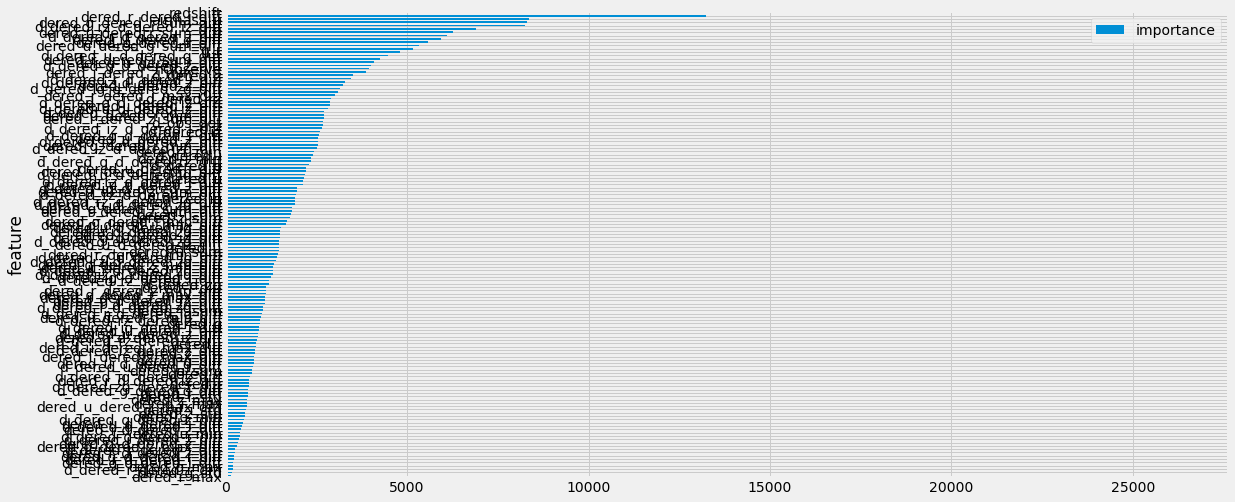

In [16]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [19]:
sub[target_col].value_counts()

2    40671
0    29975
1     9354
Name: class, dtype: int64

In [20]:
sub.to_csv(sub_file)